# Simple Collaborative Filtering in Jax

Note: The aim of this exploration was learning jax by using it to solve a practical problem - not to find the best solution to the problem.

The inspiration for this comes from [Andrew Ng's course on collaborative filtering](https://www.youtube.com/watch?v=9AP-DgFBNP4) - where he trains a model to infer feature preferences from ratings.

In [117]:
import jax.numpy as jnp
from jax import random, vmap, grad, jit
from matplotlib import pyplot as plt

A music service has a library of songs and a small number of rated songs to help calibrate a recommendation engine. This notebook shows how to use vanilla jax to simulate training data, train a model and then produce music recommendations based on a limited number of ratings that each new user supplies.

Each song as a set of features that describe it. They could include things like genre, label, mood, tempo etc. These features may be explicitly described in the song data (e.g. label), or may have to be learned from people's song ratings or other labels (e.g. mood).

The first part of this exploration will focus on the type of features that can be inferred from ratings.

## Simple simulation to create music ratings for training

First off, if we are going to learn features from song ratings we will need some song ratings. We will produce some of these by means of a simulation. In this simulation we create "clean" ratings data by building songs and ratings by trusted staff members.

In [118]:
songs = 100
features = 3   # e.g. is_jazz, is_new, is_acoustic
staff = 5
numrounds = 600
learning_rate = 0.2

Jax random numbers work differently to numpy random numbers. Random numbers generation is repeatable based on a key.

Note: This is a useful feature of jax, but it takes a bit of getting used to. You have to be ultra disciplined in the way that you assign keys as each time you need a key, you have to create a new one. If you accidentally reuse a key you will introduce unwanted correlations into your codes "random" behavior. I found the best way to stay organised is to generate a key upfront and then "split" it each time I need a new one.

In [119]:
key = random.PRNGKey(121)
key

DeviceArray([  0, 121], dtype=uint32)

The set of features produced here are simply used to generate sensible ratings to learn from. I used binary features, but this approach would work with continuous variables too. It would require tweaks to work with categorical data. The rows (axis 0) in this array are songs. The columns (axis 1) are features.

Note: When I started building models I loved the convenience of pandas. Row and column indexes make pandas data much more descriptive and the high level data manipulation features of pandas are pretty usefull. Nowadays I try to minimized the amount of dependencies in my code. This makes my code more portable and reusable so I started favoring vanilla numpy over pandas. This exploration that I am doing is all about working out if I am going to switch from vanilla numpy to jax.

In [120]:
key, sfkey = random.split(key)
song_features = random.bernoulli(sfkey, p=0.3, shape = (songs, features))
song_features[0:10,:]

DeviceArray([[False,  True, False],
             [False, False,  True],
             [False, False,  True],
             [False,  True,  True],
             [ True, False,  True],
             [ True, False,  True],
             [ True, False, False],
             [False, False, False],
             [ True,  True, False],
             [ True, False,  True]], dtype=bool)

For the purpose of making clean simulated data we will also describe how each of these features contribute to staff member ratings.

In [121]:
key, ppkey = random.split(key)
people_preferences = random.normal(key=ppkey, shape= (staff, features))
people_preferences

DeviceArray([[ 0.50482845, -1.0136279 , -0.98340374],
             [ 1.3495023 ,  0.6884206 ,  3.3923235 ],
             [ 1.0201885 ,  1.091044  ,  2.011397  ],
             [-0.5759724 , -0.47560298,  2.3675237 ],
             [-0.30214775,  0.78631365,  0.07394962]], dtype=float32)

Generate song ratings to use for training.

The formula to calculate music ratings is the simple one below: A sum of each feature multiplied by a parameter that describes the user's preference for that feature.

The calc_people_ratings function takes a set of features describing a single song and a set of parameters describing multiple users' music preferences to produce a new array dimensioned by song and user.

The output of this array is a row for each song and a column for each staff member.

In [122]:
@jit
def calc_people_ratings(song,people_preferences):
    return jnp.sum(song * people_preferences, axis = 1)

song_ratings = vmap(calc_people_ratings, in_axes=(0,None))(song_features,people_preferences)
song_ratings[0:10,:]

DeviceArray([[-1.0136279 ,  0.6884206 ,  1.091044  , -0.47560298,
               0.78631365],
             [-0.98340374,  3.3923235 ,  2.011397  ,  2.3675237 ,
               0.07394962],
             [-0.98340374,  3.3923235 ,  2.011397  ,  2.3675237 ,
               0.07394962],
             [-1.9970317 ,  4.0807443 ,  3.1024408 ,  1.8919207 ,
               0.8602633 ],
             [-0.4785753 ,  4.741826  ,  3.0315852 ,  1.7915514 ,
              -0.22819813],
             [-0.4785753 ,  4.741826  ,  3.0315852 ,  1.7915514 ,
              -0.22819813],
             [ 0.50482845,  1.3495023 ,  1.0201885 , -0.5759724 ,
              -0.30214775],
             [ 0.        ,  0.        ,  0.        ,  0.        ,
               0.        ],
             [-0.50879943,  2.0379229 ,  2.1112323 , -1.0515754 ,
               0.4841659 ],
             [-0.4785753 ,  4.741826  ,  3.0315852 ,  1.7915514 ,
              -0.22819813]], dtype=float32)

Note: Jax uses the numpy API, so lots of this code should look familiar to numpy users, the "vmap" function is something special to jax.

Vmap is actually one of the first things that drew me to jax. As a rather gross generalization "python is slow", but numpy is blazingly fast. This means that if you can push performance critical pieces of your code out of python code down into numpy, you can produce highly performant code using python. I use this strategy a lot. Sometimes you have to perform unnatural acts in numpy to push logic down into it and sometimes numpy just isn't expressive enough to do whatever you are trying to do.

The above example is a good one. Cartesian products are easy to do using loops or in sql, but they don't come naturally to numpy. I did this cartesian product that combines user data with songs inside a nifty one line function. This nifty one line function is vectorized by the jax vmap function. I also jit compiled it using the @jit decorator. I had previously done tricks like this with numba. Jax offers a lot more utility than numba. For example, I am not sure that I could change the shape of the output array in a numba vectorized function. You will see more of this increased utility later.

## Training

Now that we have some simulated song ratings, we will forget everything we knew about each user's preferences and try to learn them from the ratings.

Initialize a new set of random parameters for each user.

The goal of training is to optimize these parameters.

In [123]:
key, ppkey =random.split(key)
people_params = random.normal(key = ppkey, shape = people_preferences.shape)
people_params

DeviceArray([[ 1.1438687 ,  2.1717694 , -0.65337163],
             [ 0.8703508 , -1.2910433 , -0.32265836],
             [ 0.25262713, -0.81596595,  0.7166114 ],
             [ 0.8140667 ,  0.50421727, -1.1207098 ],
             [ 0.50041986,  2.4771438 , -0.3017055 ]], dtype=float32)

Define a loss function. This loss function computes predicted ratings using the learned parameters and compares them with the simulated ratings.
This example loss function predicts ratings using the calc function and then compares them to "known" simulated ratings and computes mean absolute error.

Iteratively optimize the parameters - moving them in the negative direction of the gradient.

In [124]:
def loss(params, target, song_data):
    pred = vmap(calc_people_ratings, in_axes=(0,None))(song_data, params)
    return jnp.mean(jnp.abs(target-pred))

for i in range(numrounds):

    current_loss = loss(people_params, target=song_ratings, song_data=song_features)
    gradient_loss = grad(loss)(people_params, song_ratings, song_features)
    people_params = people_params - gradient_loss * learning_rate

    if i % 50 == 0:
        print('iteration',i,'loss:', current_loss)

print('final loss:', loss(people_params, target=song_ratings, song_data=song_features))

iteration 0 loss: 1.4007049
iteration 50 loss: 0.881727
iteration 100 loss: 0.58476955
iteration 150 loss: 0.34664094
iteration 200 loss: 0.17135909
iteration 250 loss: 0.035004303
iteration 300 loss: 0.006438956
iteration 350 loss: 0.006438956
iteration 400 loss: 0.006438956
iteration 450 loss: 0.006438956
iteration 500 loss: 0.006438956
iteration 550 loss: 0.006438956
final loss: 0.006438956


The above demonstrates how jax differs from other libraries in that it uses functional rather than object oriented programing. It is also less "batteries included" than frameworks like sklearn so there is no "fit" method.

This functional programming style is one of the subjects of my jax test. Just like I am ensuing the convenience of pandas, I am also ensuing the convenience of classes. This is not like giving up chocolate at "Lent". Object orientation and encapsulation taught me how to code better. Why revert back to functions? I am testing the hypothesis that classes undermine reuse and complicate testing because they mix state with application logic. I want to reduce dependencies and keep my state away from my application logic. My model state in this case is the people_params. In OO libraries and frameworks these parameters would belong to a model object. I have broader thoughts about making applications faster to build and maintain and these broader thoughts imply a need to take over and manage application state in a very deliberate way. By allowing classes to own state, it undermines my broader goal. I am testing whether jax takes me closer to my broader goal.

As a quick test just to confirm that the convergence demonstrated above wasn't an illusion created inadvertently by a bug, I will compare the learned parameters with the ones that we used to simulate ratings. The learned parameters look ok.

In [131]:
people_preferences - people_params

DeviceArray([[ 0.00975922,  0.00260186,  0.00837284],
             [ 0.01275504,  0.00506359,  0.00137758],
             [ 0.00435984,  0.00620937,  0.01079082],
             [ 0.00116295,  0.00417939,  0.00263429],
             [-0.00256795, -0.00603473, -0.0123453 ]], dtype=float32)

## Understanding new user's music preferences

New users supply 3 song ratings. These 3 ratings will be used to learn their music preferences. Unlike in the simulation, this time round I am not going to cheat by learning from cleanly produced ratings. I will infer user preferences from random ratings. I didn't attempt to normalize the ratings. Let's see what they look like.

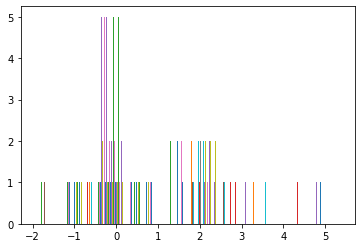

In [126]:
plt.hist(song_ratings)
plt.show()

Generate ratings for a subset of songs for new users. I could mimic the skew distribution above when making up ratings for new users, but for a quick test I will go for normally distributed ratings with a mean of zero and see what happens.

Each of 2 new users rates the first 3 songs.

In [127]:
new_members = 2
new_ratings = 3

key, nmkey = random.split(key)
new_member_ratings = random.normal(nmkey,shape= (new_ratings,new_members))
new_member_ratings.shape, new_member_ratings

((3, 2),
 DeviceArray([[ 0.7965112 , -1.0726503 ],
              [ 1.1576934 , -0.60082686],
              [ 0.36642167, -0.3806967 ]], dtype=float32))

Initialize the parameters for these new users randomly.

In [128]:
key, npkey = random.split(key)
new_member_params = random.normal(key = npkey, shape = (new_members, features))
new_member_params

DeviceArray([[ 0.27062193, -0.07210656, -1.2107201 ],
             [ 0.01730612, -1.4695468 , -0.29803303]], dtype=float32)

Iteratively find the best value of these parameters.

In [129]:
for i in range(numrounds):

    current_loss = loss(new_member_params, target=new_member_ratings, song_data = song_features[0:new_ratings, :])
    gradient_loss = grad(loss)(new_member_params, new_member_ratings, song_data = song_features[0:new_ratings, :])
    new_member_params = new_member_params - gradient_loss*learning_rate

    if i % 50 == 0:
        current_loss = loss(new_member_params, target=new_member_ratings, song_data = song_features[0:new_ratings, :])
        gradient_loss = grad(loss)(new_member_params, new_member_ratings, song_data = song_features[0:new_ratings, :])
        new_member_params = new_member_params - gradient_loss * learning_rate

        print(i,current_loss)

print('final loss:', loss(new_member_params, target=new_member_ratings, song_data=song_features[0:new_ratings, :]))

0 0.87719893
50 0.16940932
100 0.17883575
150 0.16940932
200 0.17883575
250 0.16940932
300 0.17883575
350 0.16940932
400 0.17883575
450 0.16940932
500 0.17883575
550 0.16940932
final loss: 0.16940932


Notice how the loss function didn't converge to zero nearly as well as it did before on the clean rating data. I attribute this to the fact that I used random ratings that don't follow the human mechanics of how real people would rate, and don't even conform to the distribution of the simulated ratings. It is also probably indicative of the natural bias that exists in this model as there there are only 3 binary features, so I will accept it for now.

Note: Are you bothered by the fact that I copied and pasted the training logic? I am. In a "batteries included" framework where you simply call a fit() method, there is no need to do this. Of course I could have written a fit function, but given the nature of this quick test I allowed myself to commit this infraction. There are libraries that sit on top of jax that at least supply battery holders. I will explore those in the future.

## Make Recommendations for new users

Use the optimized parameters to rate all of the songs based on the learned preferences for new members.

In [130]:
new_member_ratings = vmap(calc_people_ratings, in_axes=(0,None))(song_features,new_member_params)
new_member_ratings[0:10,:]

DeviceArray([[ 0.7945603 , -1.0695472 ],
             [ 0.38928005, -0.43136635],
             [ 0.38928005, -0.43136635],
             [ 1.1838404 , -1.5009135 ],
             [ 0.659902  , -0.41406024],
             [ 0.659902  , -0.41406024],
             [ 0.27062193,  0.01730612],
             [ 0.        ,  0.        ],
             [ 1.0651822 , -1.0522411 ],
             [ 0.659902  , -0.41406024]], dtype=float32)

The array above contains the predicted ratings for all 100 songs for the two new users.

## Conclusion

This simple example showed how to use vanilla jax to train a music recommendation model and produce music recommendations for new users. Of course it doesn't represent the state of the art in recommender systems, but it was still a useful experiment in the use of jax. This is what I learned:

1. Once you get your head around what you can do with vmap, it opens up new possibilities for writing highly performant code in python.
2. Getting your head around vmap is actually not that easy.
3. The auto gradients in jax seem to work well.
4. Lack of "batteries include" will mean having to write more code/and or understand the full jax ecosystem.
5. It was a useful experiment. I would like to extend it. I want to include a naive bayes model for inferring features from other contextual data. I would also like to see whether it could be improved - perhaps made more dynamic - using RLAX for reinforcement learning.
